SIN-392 - Introduction to Digital Image Processing (2023-1)

# Lecture 14 - Filtering in the frequency domain

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importing the libraries
---

In [1]:
import numpy as np

from scipy import ndimage
from skimage import transform, color

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

### %matplotlib inline

## Example with a simple image
---

* We will start using a simple image of a white rectangle over a dark background.

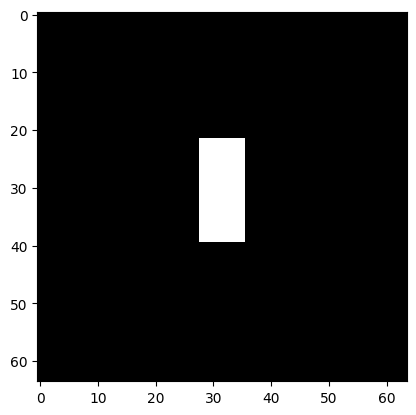

In [2]:
img_ret = np.zeros([64, 64], dtype=float)
img_ret[22:22+18, 28:28+8] = 1.

# Plot the image
plt.figure()
plt.imshow(img_ret, cmap='gray')
plt.show()

### Transforming the image

* We will generate two transformed vesions of the original image, one translated and one rotationed version.

In [3]:
# Translation
# -----------
tform = transform.EuclideanTransform(
            translation=(16, -16)
        )

img_ret_t = transform.warp(img_ret, tform.inverse)

# Rotation
# --------
shift_y, shift_x = np.array(img_ret.shape) // 2

tf_r = transform.SimilarityTransform(rotation=np.deg2rad(60))
tf_t1 = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_t2 = transform.SimilarityTransform(translation=[shift_x, shift_y])

img_ret_r = transform.warp(img_ret, (tf_t1 + (tf_r + tf_t2)).inverse, order=3)

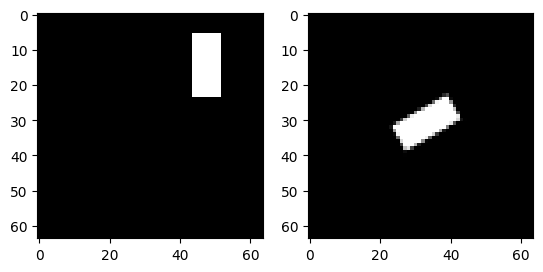

In [4]:
# Plot the image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ret_t, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_ret_r, cmap='gray')
plt.show()

### Applyng the forward Fourier Transform and the inverse Fourier Transform

In [5]:
img_list = [img_ret, img_ret_t, img_ret_r]

img_fft_list = []
img_fft_s_list = []
img_ifft_s_list = []
img_ifft_list = []

for img in img_list:
    img_fft = np.fft.fft2(img)
    img_fft_s = np.fft.fftshift(img_fft)
    img_ifft_s = np.fft.ifftshift(img_fft_s)
    img_ifft = np.fft.ifft2(img_ifft_s)
    
    img_fft_list.append(img_fft)
    img_fft_s_list.append(img_fft_s)
    img_ifft_s_list.append(img_ifft_s)
    img_ifft_list.append(img_ifft)

#### Ploting the images

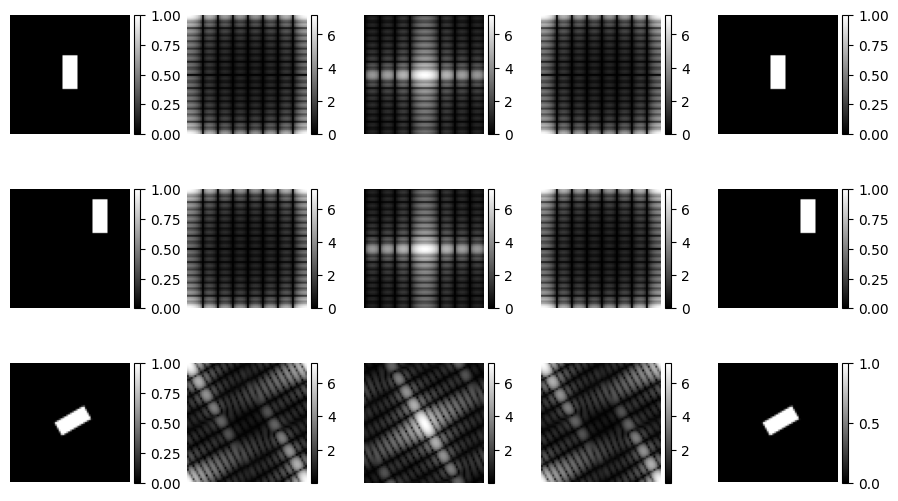

In [6]:
fig, ax  = plt.subplots(3, 5, figsize=(9,6))
for i, (img, img_fft, img_fft_s, img_ifft_s, img_ifft) in enumerate(zip(img_list, img_fft_list, img_fft_s_list, img_ifft_s_list, img_ifft_list)):

    img_1 = ax[i, 0].imshow(img, cmap='gray')
    ax[i,0].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_1, cax=cax)
    
    img_2 = ax[i,1].imshow(np.log2(1 + np.abs(img_fft)), cmap='gray')
    ax[i,1].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_2, cax=cax)
    
    img_3 = ax[i,2].imshow(np.log2(1 + np.abs(img_fft_s)), cmap='gray')
    ax[i,2].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_4 = ax[i,3].imshow(np.log2(1 + np.abs(img_ifft_s)), cmap='gray')
    ax[i,3].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,3])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_4, cax=cax)
    
    img_5 = ax[i,4].imshow(np.abs(img_ifft), cmap='gray')
    ax[i,4].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,4])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_5, cax=cax)
    
    fig.tight_layout()
    
plt.show()

## Low-pass filters
----

### Ideal low-pass filter

$$
H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) \leq D_0 \\
&0, \:\: \text{ if } D(u, v) > D_0
\end{cases}
$$


In [7]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_ideal = img_dist <= d0

[32 32]


#### Plots the transfer functions

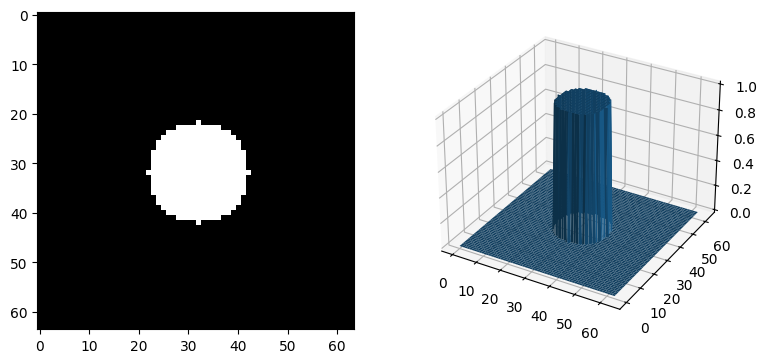

In [8]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_ideal.shape[0], 0:img_lp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Butterworth low-pass filter

$$
H(u, v) = {\frac{1}{1 + \left( {D(u, v) \over D_0} \right) ^{2n}}}
$$

In [9]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# Filter order
n = 2
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_but = 1. / (1 + (img_dist / d0)**(2 * n))

[32 32]


#### Plot the transfer function

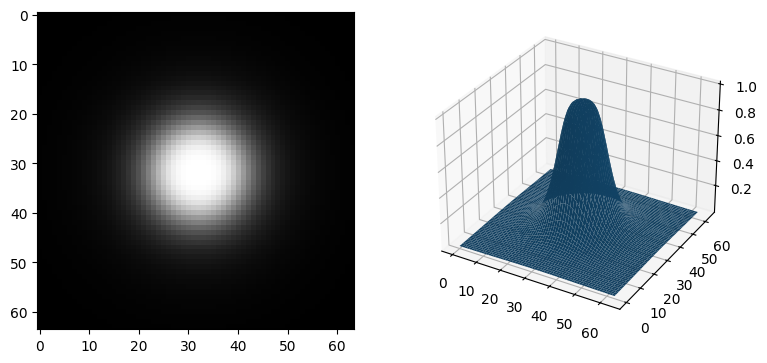

In [10]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_but.shape[0], 0:img_lp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Gaussian low-pass filter

$$
H(u, v) = e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [11]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_gaus = np.exp(-img_dist**2 / (2 * d0**2))

[32 32]


#### Plot the transfer function

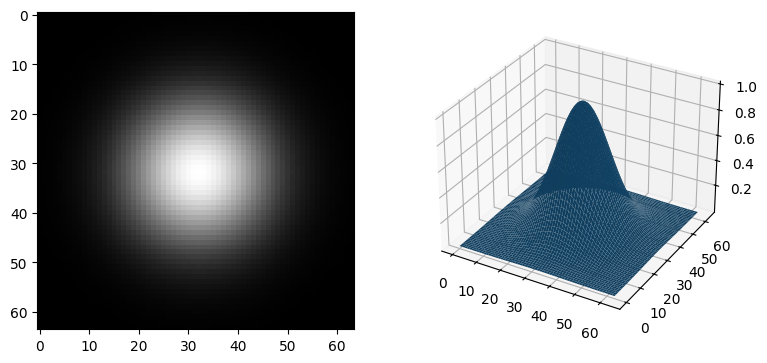

In [12]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_gaus.shape[0], 0:img_lp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

## Applying low-pass filtering with the transfer functions

### Ideal low-pass filter

In [13]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_ideal = img_ret_fft_s * img_lp_ideal

# Shifts components with zero frequency back to the image corners
img_ret_lp_ideal_ifft_s = np.fft.ifftshift(img_ret_lp_ideal)
# Inverse Fourier transform
img_ret_lp_ideal_ifft = np.fft.ifft2(img_ret_lp_ideal_ifft_s)

#### Plot the filtering process

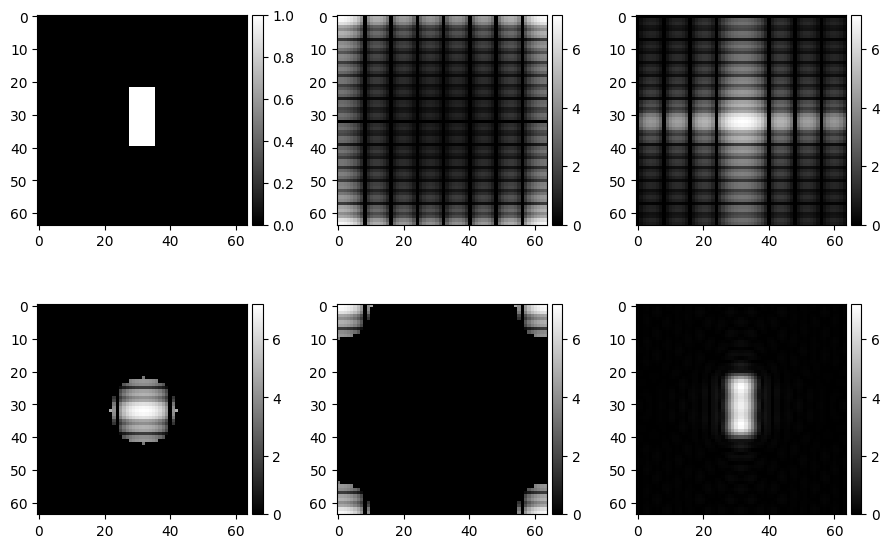

In [14]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_ideal_ifft), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Butterworth low-pass filter¶

In [15]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_but = img_ret_fft_s * img_lp_but

# Shifts components with zero frequency back to the image corners
img_ret_lp_but_ifft_s = np.fft.ifftshift(img_ret_lp_but)
# Inverse Fourier transform
img_ret_lp_but_ifft = np.fft.ifft2(img_ret_lp_but_ifft_s)

#### Ploting the images

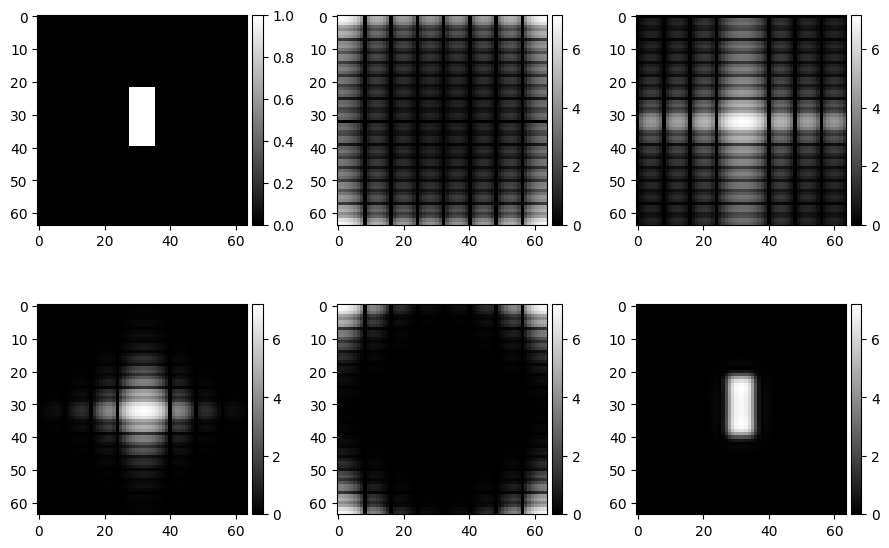

In [16]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_but)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_but_ifft), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Gaussian low-pass filter

In [17]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_gaus = img_ret_fft_s * img_lp_gaus

# Shifts components with zero frequency back to the image corners
img_ret_lp_gaus_ifft_s = np.fft.ifftshift(img_ret_lp_gaus)
# Inverse Fourier transform
img_ret_lp_gaus_ifft = np.fft.ifft2(img_ret_lp_gaus_ifft_s)

#### Ploting the images

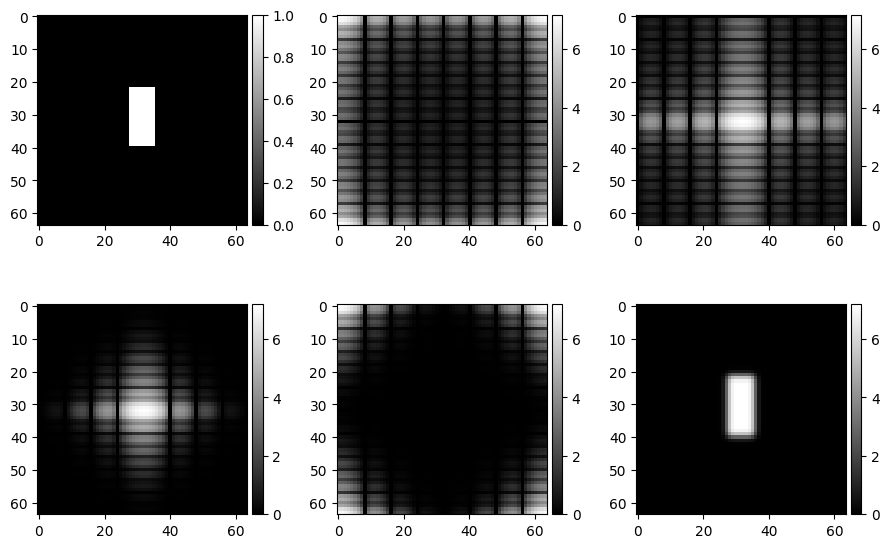

In [18]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft)), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## High-pass filters
----

### Ideal high-pass filter

<br />
<font size="5">
$H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) > D_0 \\
&0, \:\: \text{ if } D(u, v) \leq D_0
\end{cases}
$
</font>

In [19]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_ideal = img_dist > d0

[32 32]


#### Plot the transfer function

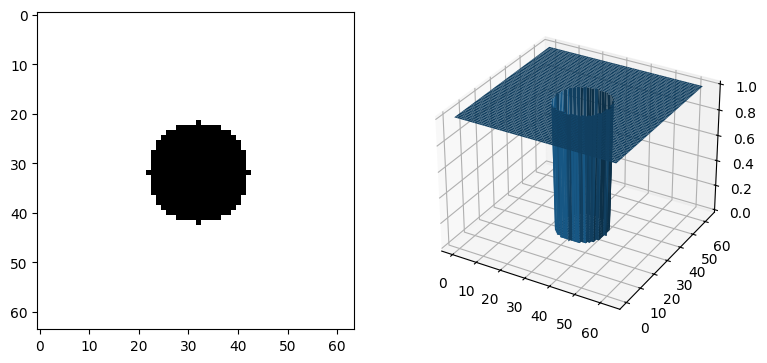

In [20]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_ideal.shape[0], 0:img_hp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Butterworth high-pass filter

<br />
<font size="5">
$H(u, v) = {\frac{1}{1 + \left( {D_0 \over D(u, v)} \right) ^{2n}}}$
</font>

In [21]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# Filter order
n = 2
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))

[32 32]


C:\Users\joaof\AppData\Local\Temp\ipykernel_11464\2532706030.py:19: RuntimeWarning: divide by zero encountered in divide
  img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))


#### Plot the transfer function

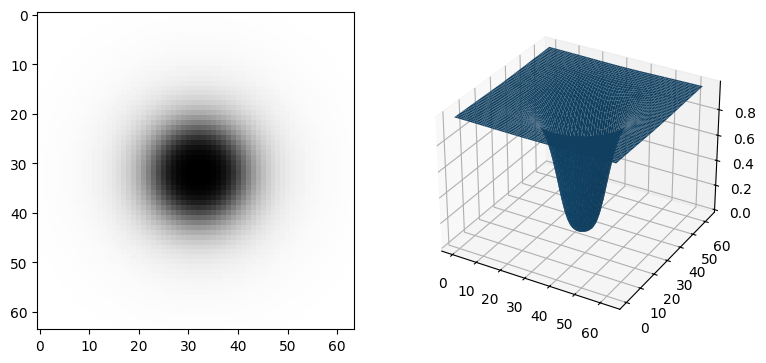

In [22]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_but.shape[0], 0:img_hp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Gaussian high-pass filter

<br />
<font size="6">
$H(u, v) = 1 - e^{\frac{-D^2(u, v)}{2 D^2_0}}$
</font>

In [23]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_gaus = 1 - np.exp(-img_dist**2 / (2 * d0**2))

[32 32]


#### Plot the transfer function

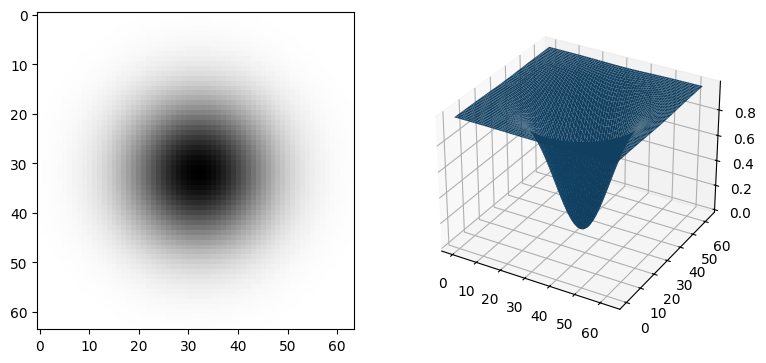

In [24]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_gaus.shape[0], 0:img_hp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

## Applying high-pass filtering with transfer functions

### Ideal high-pass filter

In [25]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_ideal = img_ret_fft_s * img_hp_ideal

# Shifts components with zero frequency back to the image corners
img_ret_hp_ideal_ifft_s = np.fft.ifftshift(img_ret_hp_ideal)
# Inverse Fourier transform
img_ret_hp_ideal_ifft = np.fft.ifft2(img_ret_hp_ideal_ifft_s)

img_ret_hp_ideal_ifft = np.abs(img_ret_hp_ideal_ifft)

#### Ploting the images

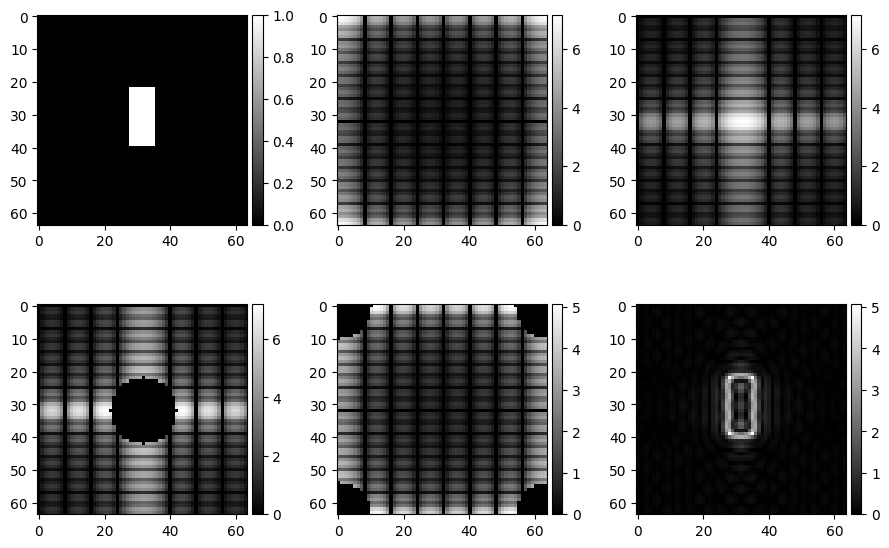

In [26]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_ideal_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

### Butterworth high-pass filter

In [27]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_but = img_ret_fft_s * img_hp_but

# Shifts components with zero frequency back to the image corners
img_ret_hp_but_ifft_s = np.fft.ifftshift(img_ret_hp_but)
# Inverse Fourier transform
img_ret_hp_but_ifft = np.fft.ifft2(img_ret_hp_but_ifft_s)

img_ret_hp_but_ifft = np.abs(img_ret_hp_but_ifft)

#### Ploting the images

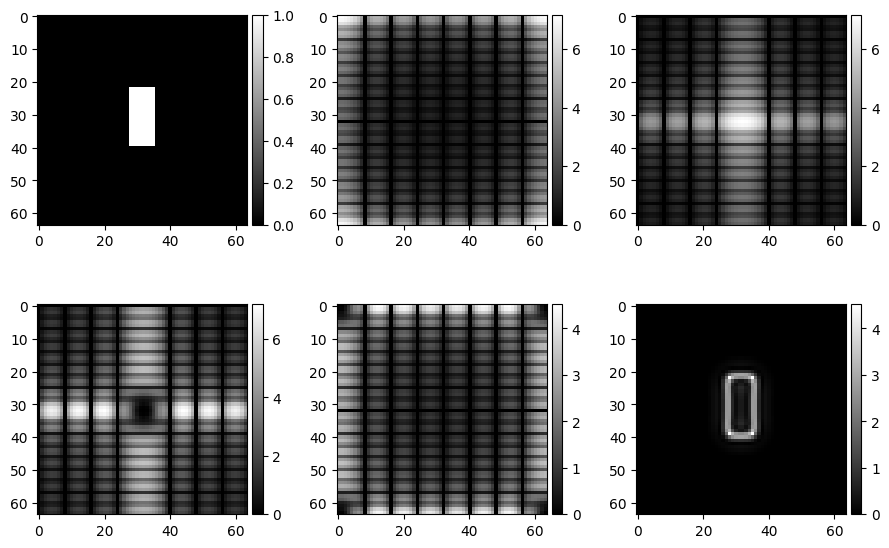

In [28]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_but)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_but_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

### Gaussian high-pass filter

In [29]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_gaus = img_ret_fft_s * img_hp_gaus

# Shifts components with zero frequency back to the image corners
img_ret_hp_gaus_ifft_s = np.fft.ifftshift(img_ret_hp_gaus)
# Inverse Fourier transform
img_ret_hp_gaus_ifft = np.fft.ifft2(img_ret_hp_gaus_ifft_s)

img_ret_hp_gaus_ifft = np.abs(img_ret_hp_gaus_ifft)

#### Ploting the images

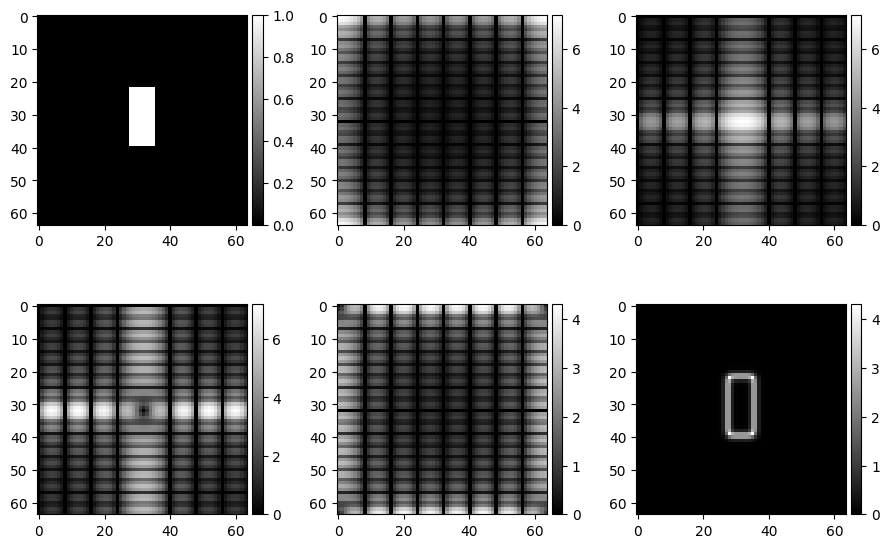

In [30]:
fig, ax  = plt.subplots(2, 3, figsize=(9,6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_gaus_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Example with a real image
---

* Now, we will repeate the previouly operations using a real image.

(512, 512) float32 0.033336863 0.99691176


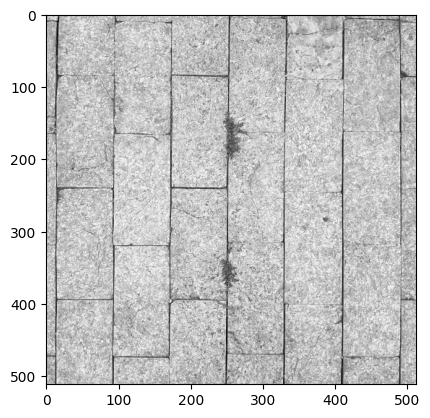

In [31]:
img_ret = plt.imread('./images/sidewalk_01_square_512x512.png')

# Remove the transparent channel
img_ret = img_ret[:,:,:-1]

# Convert to gray levels
img_ret = color.rgb2gray(img_ret)

# Information about images
print(img_ret.shape, img_ret.dtype, img_ret.min(), img_ret.max())

# Plot the image
plt.figure()
plt.imshow(img_ret, cmap='gray')
plt.show()

### Transforming the image

In [32]:
# Translation
# -----------
tform = transform.EuclideanTransform(
            translation=(16, -16))

img_ret_t = transform.warp(img_ret, tform.inverse)

# Rotation
# --------
shift_y, shift_x = np.array(img_ret.shape) // 2

tf_r = transform.SimilarityTransform(rotation=np.deg2rad(60))
tf_t1 = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_t2 = transform.SimilarityTransform(translation=[shift_x, shift_y])

img_ret_r = transform.warp(img_ret, (tf_t1 + (tf_r + tf_t2)).inverse, order=3)

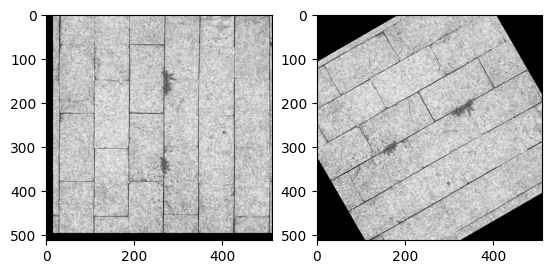

In [33]:
# Plot the image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ret_t, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_ret_r, cmap='gray')
plt.show()

### Applyng the forward Fourier Transform and the inverse Fourier Transform

In [34]:
img_list = [img_ret, img_ret_t, img_ret_r]

img_fft_list = []
img_fft_s_list = []
img_ifft_s_list = []
img_ifft_list = []

for img in img_list:
    img_fft = np.fft.fft2(img)
    img_fft_s = np.fft.fftshift(img_fft)
    img_ifft_s = np.fft.ifftshift(img_fft_s)
    img_ifft = np.fft.ifft2(img_ifft_s)
    
    img_fft_list.append(img_fft)
    img_fft_s_list.append(img_fft_s)
    img_ifft_s_list.append(img_ifft_s)
    img_ifft_list.append(img_ifft)

#### Ploting the images

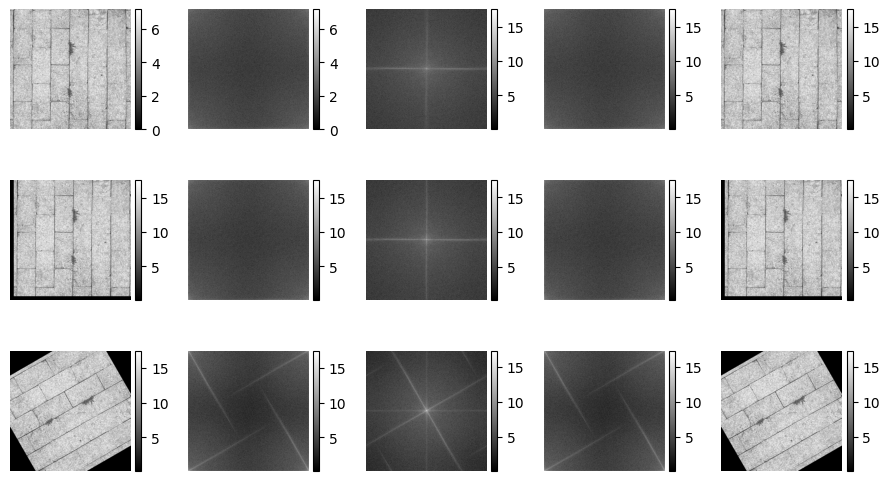

In [35]:
fig, ax  = plt.subplots(3, 5, figsize=(9,6))
for i, (img, img_fft, img_fft_s, img_ifft_s, img_ifft) in enumerate(zip(img_list, img_fft_list, img_fft_s_list, img_ifft_s_list, img_ifft_list)):

    img_1 = ax[i, 0].imshow(img, cmap='gray')
    ax[i,0].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_2 = ax[i,1].imshow(np.log2(1 + np.abs(img_fft)), cmap='gray')
    ax[i,1].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_3 = ax[i,2].imshow(np.log2(1 + np.abs(img_fft_s)), cmap='gray')
    ax[i,2].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_4 = ax[i,3].imshow(np.log2(1 + np.abs(img_ifft_s)), cmap='gray')
    ax[i,3].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,3])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_5 = ax[i,4].imshow(np.abs(img_ifft), cmap='gray')
    ax[i,4].axis('off')
    # Color bar
    divider = make_axes_locatable(ax[i,4])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    fig.tight_layout()
    
plt.show()

## Low-pass filters
----

### Ideal low-pass filter

$$
H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) \leq D_0 \\
&0, \:\: \text{ if } D(u, v) > D_0
\end{cases}
$$

In [36]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_ideal = img_dist <= d0

[256 256]


#### Plots the transfer functions

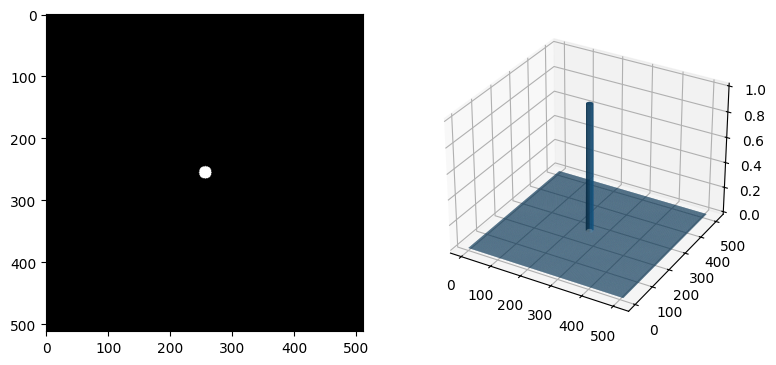

In [37]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_ideal.shape[0], 0:img_lp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Butterworth low-pass filter

$$
H(u, v) = {\frac{1}{1 + \left( {D(u, v) \over D_0} \right) ^{2n}}}
$$

In [38]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# Filter order
n = 2
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_but = 1. / (1 + (img_dist / d0)**(2 * n))

[256 256]


#### Plot the transfer function

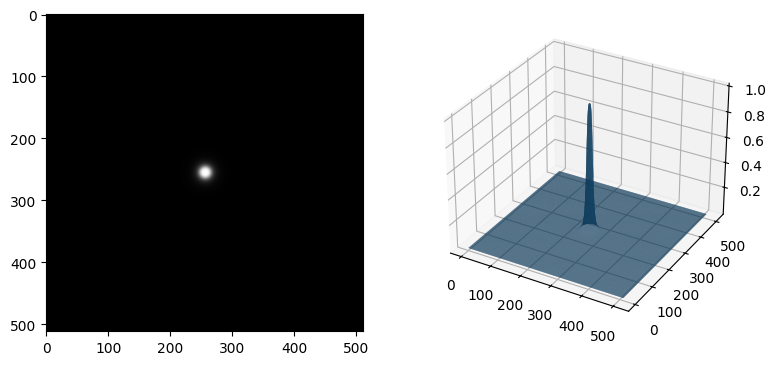

In [39]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_but.shape[0], 0:img_lp_but.shape[1]]
ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Gaussian low-pass filter

$$
H(u, v) = e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [40]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_gaus = np.exp(-img_dist**2 / (2 * d0**2))

[256 256]


#### Plot the transfer function

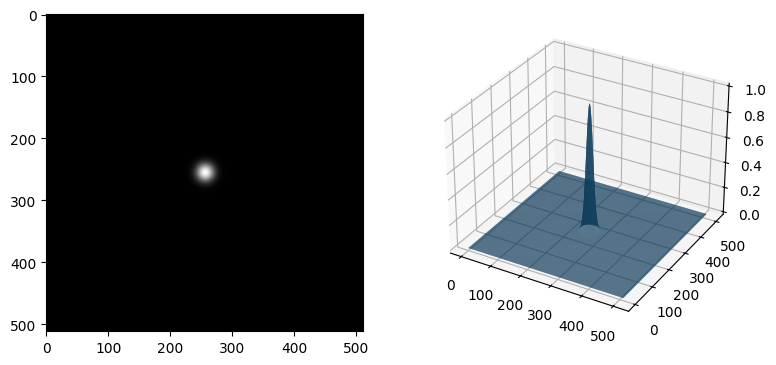

In [41]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_lp_gaus.shape[0], 0:img_lp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Applying low-pass filtering with the transfer functions

#### Ideal low-pass filter

In [42]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_ideal = img_ret_fft_s * img_lp_ideal

# Shifts components with zero frequency back to the image corners
img_ret_lp_ideal_ifft_s = np.fft.ifftshift(img_ret_lp_ideal)
# Inverse Fourier transform
img_ret_lp_ideal_ifft = np.fft.ifft2(img_ret_lp_ideal_ifft_s)

##### Plot the filtering process

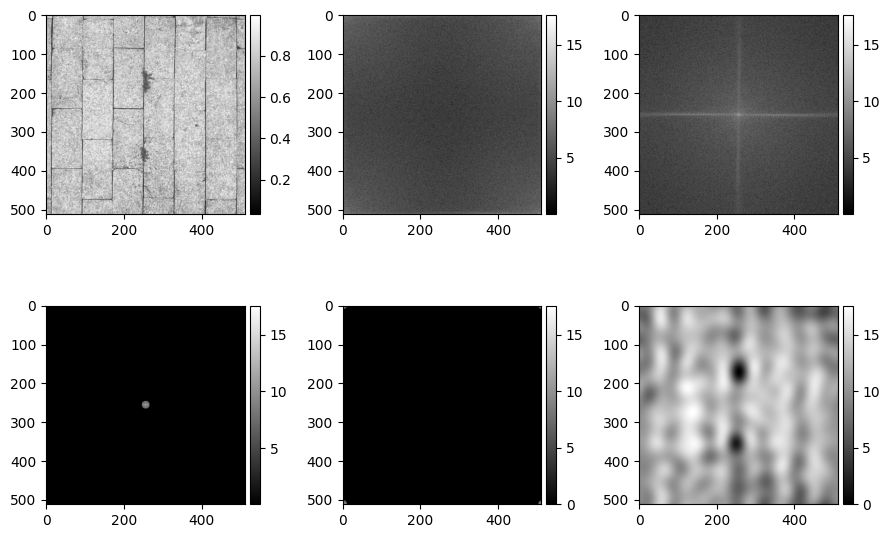

In [43]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_ideal_ifft), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Butterworth low-pass filter

In [44]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_but = img_ret_fft_s * img_lp_but

# Shifts components with zero frequency back to the image corners
img_ret_lp_but_ifft_s = np.fft.ifftshift(img_ret_lp_but)
# Inverse Fourier transform
img_ret_lp_but_ifft = np.fft.ifft2(img_ret_lp_but_ifft_s)

##### Plot the filtering process

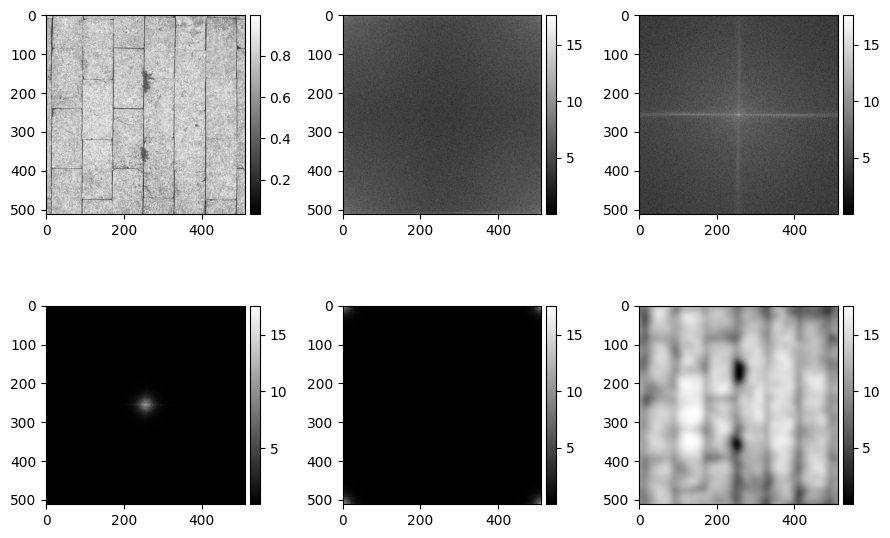

In [45]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_but)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_but_ifft), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Gaussian low-pass filter

In [46]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the low-pass filter (by multiplication)...
img_ret_lp_gaus = img_ret_fft_s * img_lp_gaus

# Shifts components with zero frequency back to the image corners
img_ret_lp_gaus_ifft_s = np.fft.ifftshift(img_ret_lp_gaus)
# Inverse Fourier transform
img_ret_lp_gaus_ifft = np.fft.ifft2(img_ret_lp_gaus_ifft_s)

##### Plot the filtering process

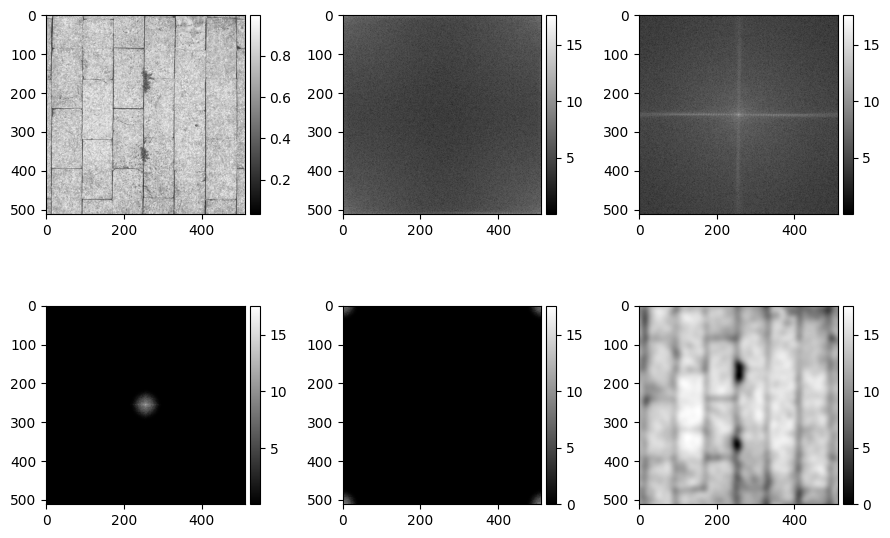

In [47]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft)), cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## High-pass filters
----

### Ideal high-pass filter

$$
H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) > D_0 \\
&0, \:\: \text{ if } D(u, v) \leq D_0
\end{cases}
$$

In [48]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_ideal = img_dist > d0

[256 256]


#### Plotting the transition function

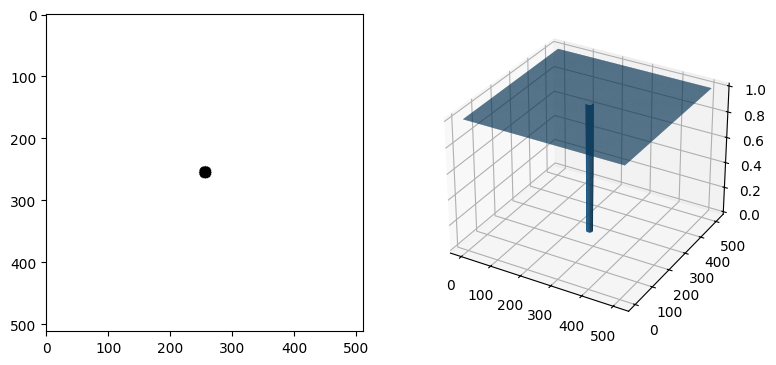

In [49]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_ideal.shape[0], 0:img_hp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Butterworth high-pass filter

$$
H(u, v) = {\frac{1}{1 + \left( {D_0 \over D(u, v)} \right) ^{2n}}}
$$

In [50]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# Filter order
n = 2

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))

[256 256]


C:\Users\joaof\AppData\Local\Temp\ipykernel_11464\1248810622.py:18: RuntimeWarning: divide by zero encountered in divide
  img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))


#### Plotting the transition function

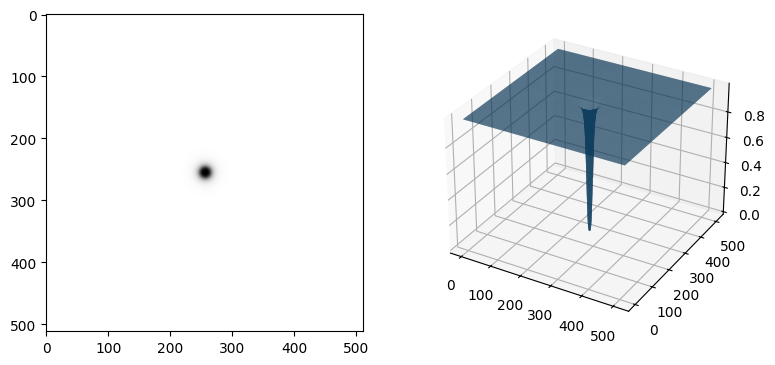

In [51]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_but.shape[0], 0:img_hp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Gaussian high-pass filter

$$
H(u, v) = 1 - e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [52]:
# Parameters
# ----------------------------------------
# Cutoff frequency
d0 = 10
# ----------------------------------------

# Center pixel coordinates
center = np.array(img_ret.shape) // 2
print(center)

# Distances of all pixels from the center of the image
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Euclidean distance transform
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_gaus = 1 - np.exp(-img_dist**2 / (2 * d0**2))

[256 256]


#### Plotting the transition function

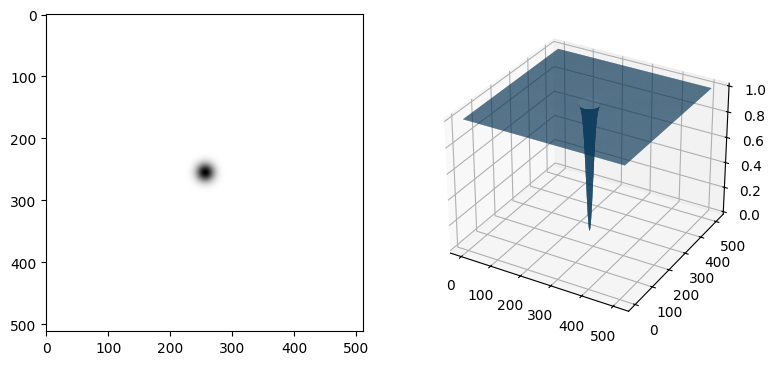

In [53]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Arrays with the x and y coordinate (pixel indices)
xx, yy = np.mgrid[0:img_hp_gaus.shape[0], 0:img_hp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Applying high-pass filtering with transfer functions

#### Ideal high pass filter

In [54]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_ideal = img_ret_fft_s * img_hp_ideal

# Shifts components with zero frequency back to the image corners
img_ret_hp_ideal_ifft_s = np.fft.ifftshift(img_ret_hp_ideal)
# Inverse Fourier transform
img_ret_hp_ideal_ifft = np.fft.ifft2(img_ret_hp_ideal_ifft_s)

img_ret_hp_ideal_ifft = np.abs(img_ret_hp_ideal_ifft)

##### Plotting the images

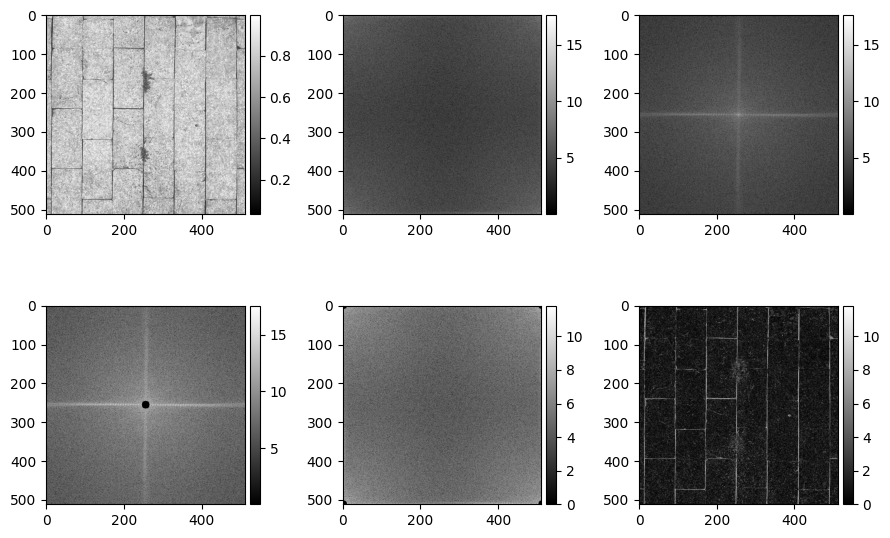

In [55]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_ideal_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

#### Butterworth high-pass filter

In [56]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_but = img_ret_fft_s * img_hp_but

# Shifts components with zero frequency back to the image corners
img_ret_hp_but_ifft_s = np.fft.ifftshift(img_ret_hp_but)
# Inverse Fourier transform
img_ret_hp_but_ifft = np.fft.ifft2(img_ret_hp_but_ifft_s)

img_ret_hp_but_ifft = np.abs(img_ret_hp_but_ifft)

##### Plotting the images

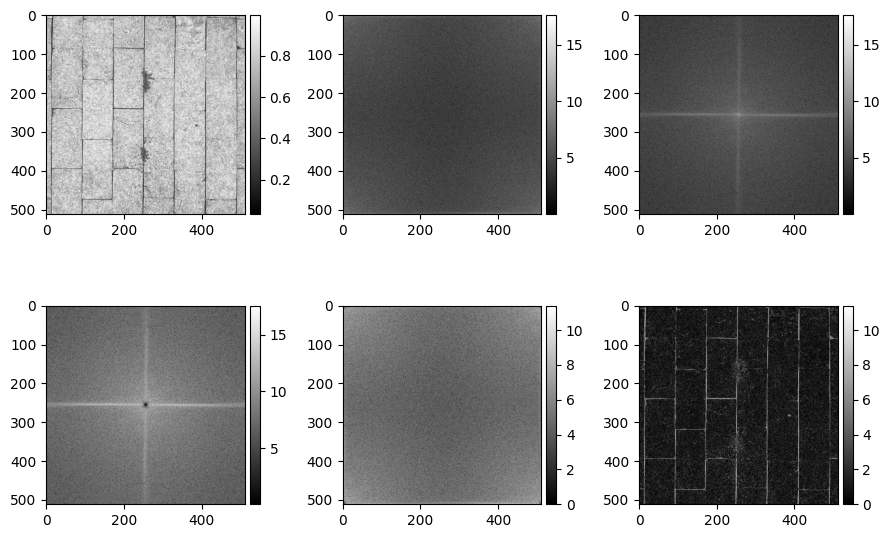

In [57]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_but)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_but_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

#### Gaussian high-pass filter

In [58]:
# Compute the Fourier Transform
img_ret_fft = np.fft.fft2(img_ret)
# Shifts components with zero frequency to the center of the image
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Apply the high-pass filter (by multiplication)...
img_ret_hp_gaus = img_ret_fft_s * img_hp_gaus

# Shifts components with zero frequency back to the image corners
img_ret_hp_gaus_ifft_s = np.fft.ifftshift(img_ret_hp_gaus)
# Inverse Fourier transform
img_ret_hp_gaus_ifft = np.fft.ifft2(img_ret_hp_gaus_ifft_s)

img_ret_hp_gaus_ifft = np.abs(img_ret_hp_gaus_ifft)

##### Plotting the images

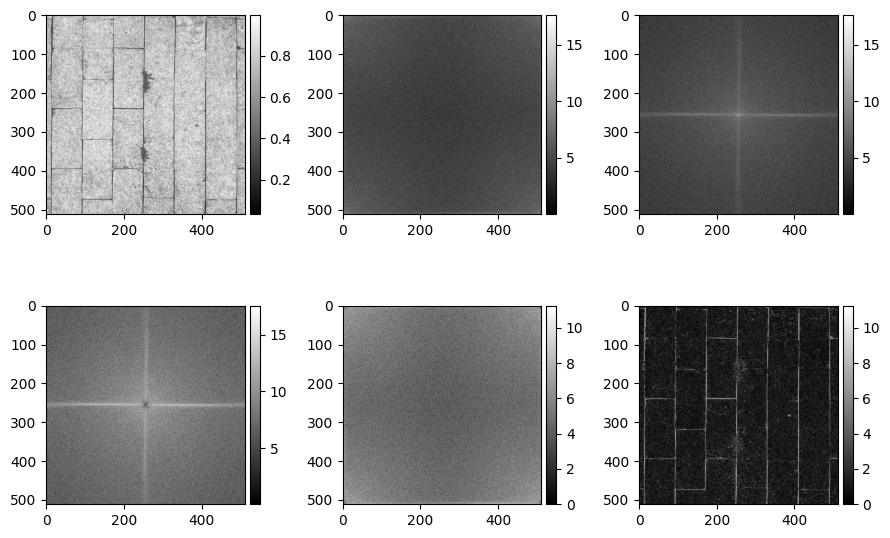

In [59]:
fig, ax  = plt.subplots(2, 3, figsize=(9,6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_gaus_ifft, cmap='gray')
## ax[i,4].axis('off')
# Color bar
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Bibliography
----

* GONZALEZ, R.C.; WOODS, R.E.; Digital Image Processing. 3rd edition. Pearson, 2009.
* MARQUES FILHO, O.; VIEIRA NETO, H. Processamento digital de imagens. Brasport, 1999.
    * In Brazilian Portuguese.
    * Available for download on the author's website (Personal use only).
    * http://dainf.ct.utfpr.edu.br/~hvieir/pub.html  
* J. E. R. Queiroz, H. M. Gomes. Introdução ao Processamento Digital de Imagens. RITA. v. 13, 2006.
    * In Brazilian Portuguese.
    * http://www.dsc.ufcg.edu.br/~hmg/disciplinas/graduacao/vc-2016.2/Rita-Tutorial-PDI.pdf  
* Gaël Varoquaux Emmanuelle Gouillart; Olav Vahtras; Pierre de Buyl (editores). Scipy Lecture Notes. Release 2020.1
    * Disponível em: http://scipy-lectures.org/
* scikit-image. Documentation.
    * https://scikit-image.org/docs/dev/index.html
* NumPy. Documentation.
    * https://numpy.org/doc/stable/
* Plotting and manipulating FFTs for filtering
    * https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html
* Understanding the FFT Algorithm 
    * https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/
* Digital Image Processing using Fourier Transform in Python
    * https://medium.com/@hicraigchen/digital-image-processing-using-fourier-transform-in-python-bcb49424fd82